# **Model interpertability with Lime**

## **1. Abstract**

The notebook aims for the model interpretability with LIME and notebook also aims to classify the humans and horses by using the neural network and the convolution using TensorFlow.

## **2. Importing necessary libraries**

In [1]:
import os
import tensorflow as tf
import os 
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import random
print('Notebook run using keras:', keras.__version__)
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


Notebook run using keras: 2.3.1


## **3. Giving path to the directories**

In [2]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('validation-horse-or-human/validation-horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('validation-horse-or-human/validation-humans')

In [3]:
print(tf.__version__)

1.15.0


## **4. Define the network architecture with convolution layers**

In [4]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
   # The fourth convolution
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(2, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 8)         1

In [6]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='mse',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

##  **5. Data Preprocessing**

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. 

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        'validation-horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    directory=r"test-horse-or-human",
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=8,
    class_mode=None,
    shuffle=False
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 8 images belonging to 1 classes.


In [8]:
image =next(test_generator)

In [9]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=3, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

## **6. Training**

In [10]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=30,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
        callbacks=callbacks_list)

Epoch 1/30
8/8 [==============================] - 3s 360ms/step - loss: 0.2185 - acc: 0.7617

Epoch 00001: val_loss improved from inf to 0.21851, saving model to model.h5
8/8 [==============================] - 39s 5s/step - loss: 0.2594 - acc: 0.5039 - val_loss: 0.2185 - val_acc: 0.7617
Epoch 2/30
8/8 [==============================] - 3s 398ms/step - loss: 0.1606 - acc: 0.7891

Epoch 00002: val_loss improved from 0.21851 to 0.16059, saving model to model.h5
8/8 [==============================] - 36s 5s/step - loss: 0.2424 - acc: 0.6496 - val_loss: 0.1606 - val_acc: 0.7891
Epoch 3/30
8/8 [==============================] - 3s 387ms/step - loss: 0.2079 - acc: 0.6680

Epoch 00003: val_loss did not improve from 0.16059
8/8 [==============================] - 36s 5s/step - loss: 0.2935 - acc: 0.6218 - val_loss: 0.2079 - val_acc: 0.6680
Epoch 4/30
8/8 [==============================] - 3s 373ms/step - loss: 0.1605 - acc: 0.7930

Epoch 00004: val_loss improved from 0.16059 to 0.16053, saving m

## **7. Predicting the image class**

In [11]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

1/1 [==============================] - 0s 351ms/step


In [12]:
predicted_class_indices=np.argmax(pred,axis=1)

In [13]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

99.99997615814209 is a horse


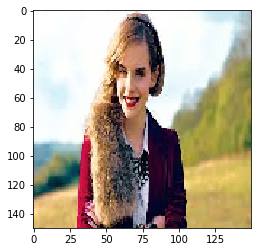

In [14]:
k= 1

f = max(pred[k])*100

f= str(f)
if pred[k][0]>0.5:
    print(f + " is a horse")
else:
    print(f + " is a human")
    
image =next(test_generator)
plt.imshow(image[k])

## **9. LIME for model interpretation**


### **9.1 Installing LIME**

!pip install -q lime

In [15]:
%reload_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [16]:
explainer = lime_image.LimeImageExplainer()

In [17]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image[0],model.predict, top_labels=5, hide_color=0, num_samples=1000)


Wall time: 10.4 s


In [18]:
from skimage.segmentation import mark_boundaries #Using segmentation to understand better

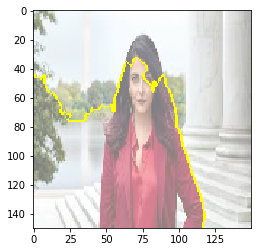

In [19]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

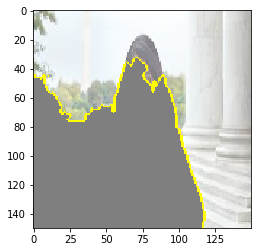

In [20]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

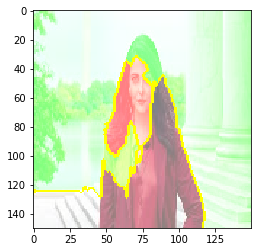

In [21]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

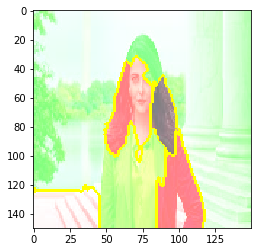

In [22]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1200, hide_rest=False, min_weight=0.001)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [23]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image[6],model.predict, top_labels=5, hide_color=0, num_samples=1000)


Wall time: 9.29 s


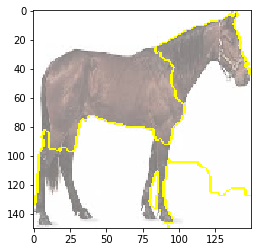

In [24]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

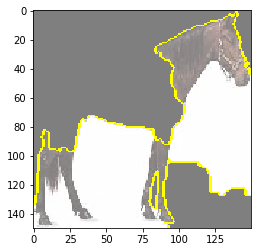

In [25]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

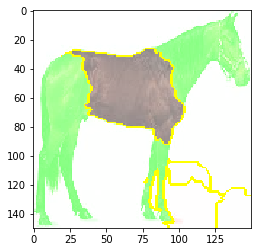

In [26]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

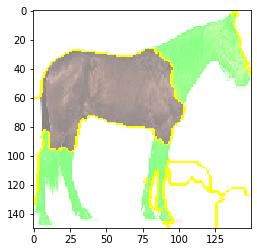

In [27]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1200, hide_rest=False, min_weight=0.001)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

So we can clearly see the part of the image highlighted and used for the predicting which class the particular image belongs to.

## **9. Conclusion**

It was able to predict another image that was not seen by the model with very good probability. Lime helps to model interpretation and get to know exactly what model is looking for making predicition and it good tool for making local interpretation.


### **10. Refrence** 

1. https://www.coursera.org/learn/introduction-tensorflow/home/welcome
2. https://www.tensorflow.org/
3. https://lime-ml.readthedocs.io/en/latest/
4. https://github.com/marcotcr/lime/blob/master/doc/index.rst

Copyright 2020 Abhishek Gargha Maheshwarappa and Kartik Kumar

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.